In [1]:
import pandas as pd
from autogluon.tabular import TabularDataset, TabularPredictor
from autogluon.fair import FairPredictor
from autogluon.fair.utils import group_metrics as gm
from train_compas_ensemble import run_default_training


/Users/tp366/miniforge3/envs/compas/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# load or train models 
model_no_race = 'AutogluonModels/model_1y_no_race/'
model_race = 'AutogluonModels/model_1y_race/'

try:
    predictor = TabularPredictor.load(model_no_race)
except:
    run_default_training(model_no_race, use_race=False)

try:
    predictor_race = TabularPredictor.load(model_race)
except:
    predictor_race=run_default_training(model_race, use_race=False)

This means that the predictor was fit in a version `<=0.3.1`.
INFO:root:Dropping columns: ['person_id']
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/model_1y_no_race/"
AutoGluon Version:  0.8.2
Python Version:     3.8.18
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 23.3.0: Wed Dec 20 21:31:00 PST 2023; root:xnu-10002.81.5~7/RELEASE_ARM64_T6020
Disk Space Avail:   149.52 GB / 994.66 GB (15.0%)
Train Data Rows:    23510
Train Data Columns: 855
Tuning Data Rows:    7759
Tuning Data Columns: 855
Label Column: pred_label
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1, 0]
	If 'binary' is not the corre

In [8]:
years = 1

train = pd.read_parquet(f'joined_data/compas_v2_all_{years}y-label_train.pqt')
test = pd.read_parquet(f'joined_data/compas_v2_all_{years}y-label_test.pqt')

current_label = 'pred_label' 

all_pred_labels = []
for c in train.columns:
    if '_label' in c:
        all_pred_labels.append(c)

drop_cols =  list(set(all_pred_labels+['person_id'])-set([current_label] ))
print('Dropping columns:', drop_cols)
train = train.drop(columns=drop_cols)
test = test.drop(columns=drop_cols)
print(test.shape)

Dropping columns: ['person_id']
(7505, 857)


In [9]:
# Modify predictor to enforce fairness over the train data with respect to groups given by the column 'race'
fpredictor = FairPredictor(predictor,train,'race')
# Maximize accuracy while enforcing that the demographic parity (the difference in positive decision rates between different races is at most 0.02)
fpredictor.fit(gm.f1,gm.demographic_parity,0.02)
fpredictor.evaluate(test, verbose=True)

,original,updated
Accuracy,0.707262,0.602931
Balanced Accuracy,0.609779,0.638279
F1 score,0.423208,0.492852
MCC,0.228938,0.245594
Precision,0.451794,0.376006
Recall,0.398025,0.715062
roc_auc,0.702271,0.685428


In [10]:
out = fpredictor.evaluate_groups(test, verbose=True, return_original=True)
out.index

MultiIndex([('original',            'Overall'),
            ('original',   'african-american'),
            ('original',              'asian'),
            ('original',          'caucasian'),
            ('original',           'hispanic'),
            ('original',    'native american'),
            ('original',              'other'),
            ('original', 'Maximum difference'),
            ( 'updated',            'Overall'),
            ( 'updated',   'african-american'),
            ( 'updated',              'asian'),
            ( 'updated',          'caucasian'),
            ( 'updated',           'hispanic'),
            ( 'updated',    'native american'),
            ( 'updated',              'other'),
            ( 'updated', 'Maximum difference')],
           names=[None, 'Groups'])

In [11]:
# Modify predictor to enforce fairness over the train data with respect to groups given by the column 'race'
fpredictor_race = FairPredictor(predictor_race,train,'race')
# Maximize accuracy while enforcing that the demographic parity (the difference in positive decision rates between different races is at most 0.02)
fpredictor_race.fit(gm.f1,gm.demographic_parity,0.02)
fpredictor_race.evaluate(test, verbose=True)


,original,updated
Accuracy,0.707262,0.602931
Balanced Accuracy,0.609779,0.638279
F1 score,0.423208,0.492852
MCC,0.228938,0.245594
Precision,0.451794,0.376006
Recall,0.398025,0.715062
roc_auc,0.702271,0.685428


In [10]:
out_race = fpredictor_race.evaluate_groups(test, verbose=True, return_original=True)
ind_names = out_race.index.names

ind_vals = out_race.index.to_list()
ind_vals = [(i+'_race', j) for i,j in ind_vals] 
out_race.index = pd.MultiIndex.from_tuples(ind_vals, names=ind_names)

out_race

Accuracy  Balanced Accuracy  F1 score  \
              Groups                                                      
original_race Overall             0.725250           0.605284  0.403702   
              african-american    0.689579           0.611539  0.448532   
              asian               0.809524           0.472222  0.000000   
              caucasian           0.768456           0.560155  0.267071   
              hispanic            0.778584           0.571704  0.290698   
              native american     0.806452           0.672619  0.500000   
              other               0.862816           0.615587  0.321429   
              Maximum difference  0.173237           0.200397  0.500000   
updated_race  Overall             0.655163           0.632792  0.477594   
              african-american    0.645957           0.630792  0.512883   
              asian               0.714286           0.694444  0.400000   
              caucasian           0.678332           0.628387  0.414996   
              hispanic            0.627949           0.622215  0.398827   
              native american     0.741935           0.782738  0.600000   
              other               0.671480           0.713293  0.335766   
              Maximum difference  0.113986           0.160523  0.264234   

                                       MCC  Precision    Recall   roc_auc  \
              Groups                                                        
original_race Overall             0.237796   0.487090  0.344691  0.697338   
              african-american    0.240595   0.511607  0.399303  0.681213   
              asian              -0.091287   0.000000  0.000000  0.648148   
              caucasian           0.159666   0.400000  0.200456  0.687837   
              hispanic            0.183314   0.409836  0.225225  0.656143   
              native american     0.392466   0.600000  0.428571  0.833333   
              other               0.246334   0.346154  0.300000  0.754521   
              Maximum difference  0.483753   0.600000  0.428571  0.185185   
updated_race  Overall             0.241659   0.403892  0.584198  0.681350   
              african-american    0.247236   0.453863  0.589547  0.681213   
              asian               0.288675   0.285714  0.666666  0.648148   
              caucasian           0.221049   0.336158  0.542141  0.687837   
              hispanic            0.198805   0.295652  0.612613  0.656143   
              native american     0.479138   0.461538  0.857143  0.833333   
              other               0.272270   0.214953  0.766667  0.754521   
              Maximum difference  0.280333   0.246585  0.315002  0.185185   

                                  Number of Datapoints  Positive Count  \
              Groups                                                     
original_race Overall                           7505.0          2025.0   
              african-american                  4539.0          1435.0   
              asian                               21.0             3.0   
              caucasian                         2086.0           439.0   
              hispanic                           551.0           111.0   
              native american                     31.0             7.0   
              other                              277.0            30.0   
              Maximum difference                4518.0          1432.0   
updated_race  Overall                           7505.0          2025.0   
              african-american                  4539.0          1435.0   
              asian                               21.0             3.0   
              caucasian                         2086.0           439.0   
              hispanic                           551.0           111.0   
              native american                     31.0             7.0   
              other                              277.0            30.0   
              Maximum difference      

In [11]:
out = pd.concat([out, out_race])

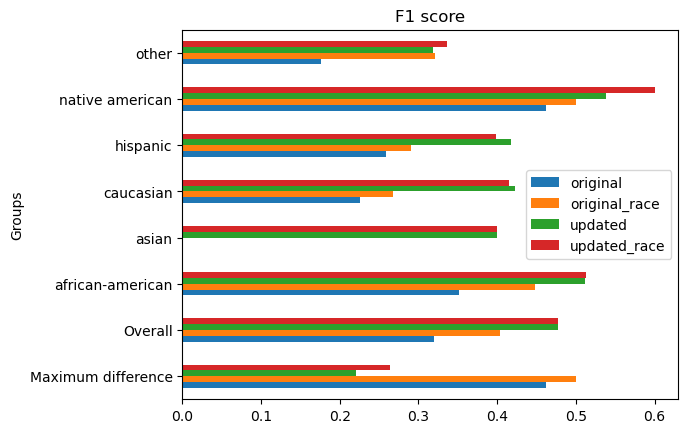

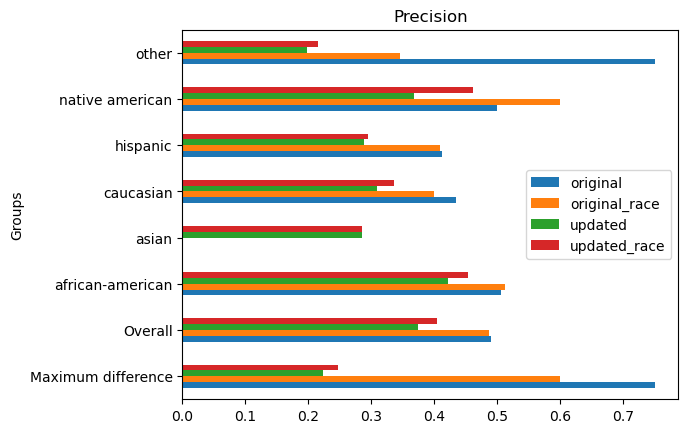

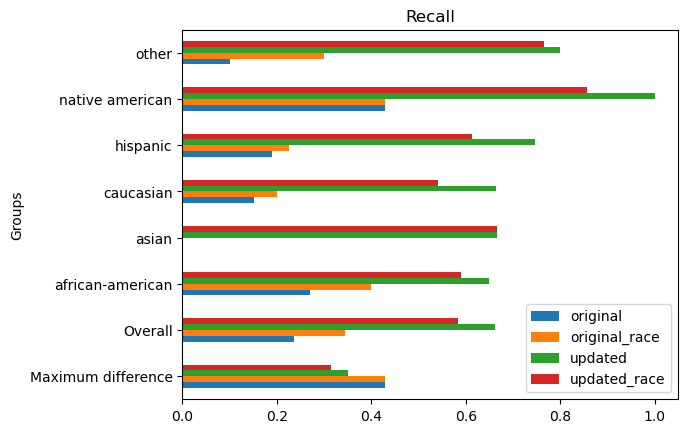

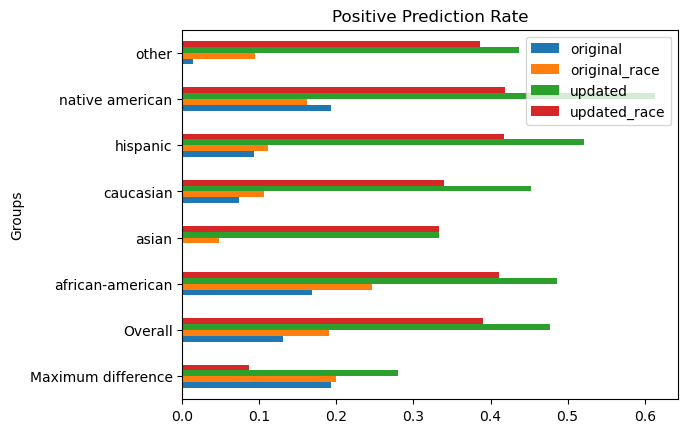

In [12]:
for col in ['F1 score', 'Precision', 'Recall', 'Positive Prediction Rate']:
    out[col].unstack(0).plot.barh(title=col)


In [13]:
out2 = fpredictor.evaluate_groups(test,return_original=True, metrics=gm.standard_metrics, verbose=True)
out2_race = fpredictor_race.evaluate_groups(test, return_original=True, metrics=gm.standard_metrics, verbose=True)
ind_names = out_race.index.names

ind_vals = out2_race.index.to_list()
ind_vals = [(i+'_race', j) for i,j in ind_vals] 
out2_race.index = pd.MultiIndex.from_tuples(ind_vals, names=ind_names)
out2 = pd.concat([out2, out2_race])



True Positive Rate  True Negative Rate  \
              Groups                                                       
original      Overall                       0.237531            0.908942   
              african-american              0.269686            0.878222   
              asian                         0.000000            1.000000   
              caucasian                     0.152620            0.947177   
              hispanic                      0.189189            0.931818   
              native american               0.428571            0.875000   
              other                         0.100000            0.995951   
              Maximum difference            0.428571            0.125000   
updated       Overall                       0.661728            0.590328   
              african-american              0.649477            0.589240   
              asian                         0.666666            0.722222   
              caucasian                     0.665148            0.604129   
              hispanic                      0.747748            0.536364   
              native american               1.000000            0.500000   
              other                         0.800000            0.607287   
              Maximum difference            0.350523            0.222222   
original_race Overall                       0.344691            0.865876   
              african-american              0.399303            0.823776   
              asian                         0.000000            0.944444   
              caucasian                     0.200456            0.919854   
              hispanic                      0.225225            0.918182   
              native american               0.428571            0.916667   
              other                         0.300000            0.931174   
              Maximum difference            0.428571            0.120669   
updated_race  Overall                       0.584198            0.681387   
              african-american              0.589547            0.672036   
              asian                         0.666666            0.722222   
              caucasian                     0.542141            0.714633   
              hispanic                      0.612613            0.631818   
              native american               0.857143            0.708333   
              other                         0.766667            0.659919   
              Maximum difference            0.315002            0.090404   

                                  False Positive Rate  False Negative Rate  \
              Groups                                                         
original      Overall                        0.091058             0.762469   
              african-american               0.121778             0.730314   
              asian                          0.000000             1.000000   
              caucasian                      0.052823             0.847380   
              hispanic                       0.068182             0.810811   
              native american                0.125000             0.571428   
              other                          0.004049             0.900000   
              Maximum difference             0.125000             0.428571   
updated       Overall                        0.409672             0.338272   
              african-american               0.410760             0.350523   
              asian                          0.277778             0.333333   
              caucasian                      0.395871             0.334852   
              hispanic                       0.463636             0.252252   
              native american                0.500000             0.000000   
              other                          0.392713             0.200000   
              Maximum difference             0.222222             0.350523   
original_race Overall                        

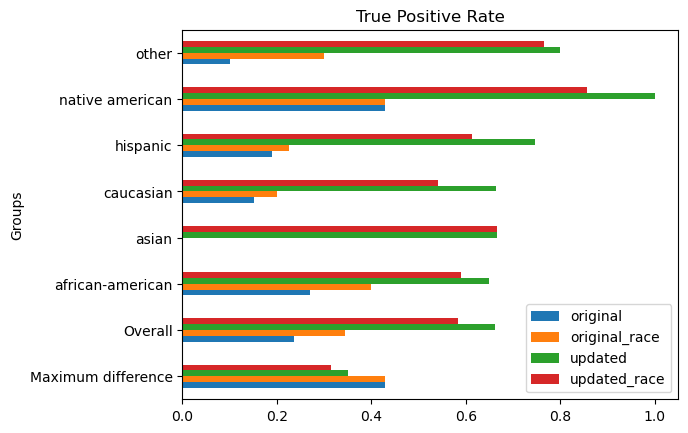

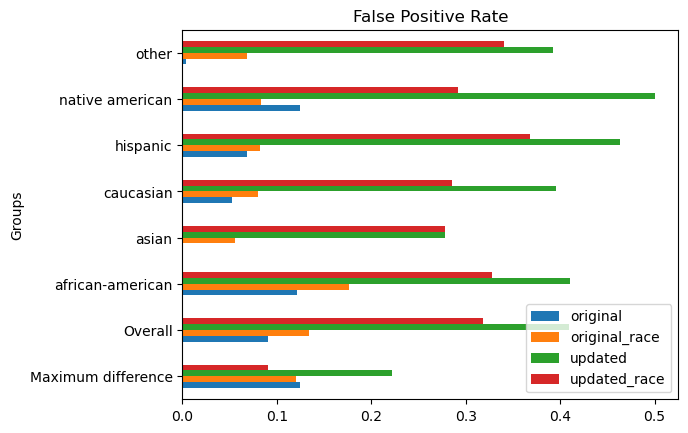

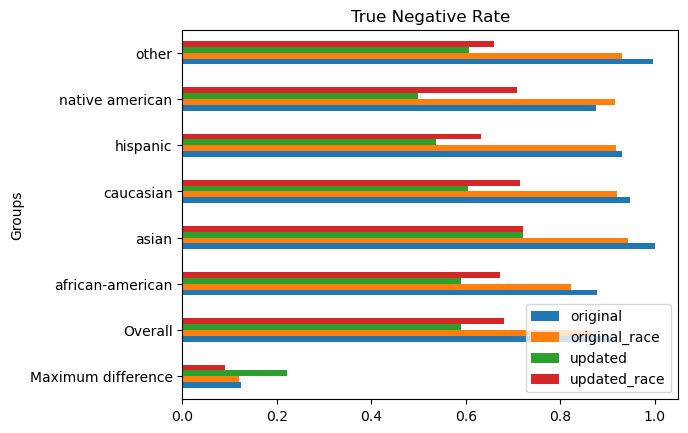

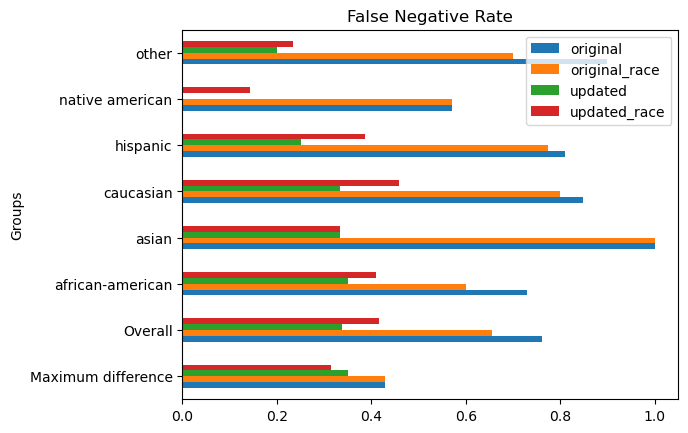

In [15]:
for col in ['True Positive Rate','False Positive Rate', 'True Negative Rate', 'False Negative Rate']:
    out2[col].unstack(0).plot.barh(title=col)

In [16]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

def roc(model, test):
    plt.clf()
    probs = model.predict_proba(test)
    test['probs'] = probs.iloc[:,1]

    fpr, tpr, threshold = metrics.roc_curve(test[current_label], test['probs'])
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label = f'AUC = {roc_auc:0.2f} overall')
    for g in test['race'].unique():
       
        test_g = test[test['race']==g]
       
        fpr, tpr, threshold = metrics.roc_curve(test_g[current_label], test_g['probs'])

        roc_auc = metrics.auc(fpr, tpr)

        plt.plot(fpr, tpr, label = f'AUC = {roc_auc:0.2f} {g}')
    

    plt.title('Receiver Operating Characteristic')

    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    test = test.drop(columns=['probs'])

original


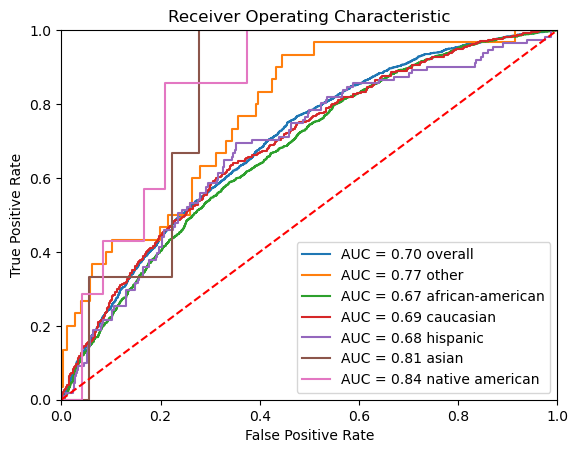

fair


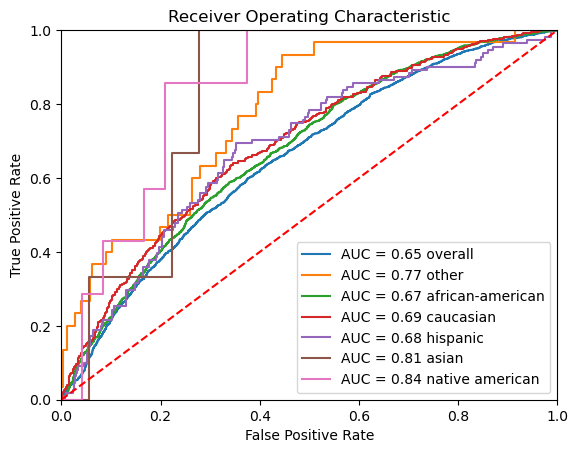

In [17]:
print('original')
roc(predictor, test)
print('fair')
roc(fpredictor, test)

In [18]:
# print ROC 

probs = fpredictor.predict_proba(test)
print(probs.iloc[:,1])
fpr, tpr, threshold = metrics.roc_curve(test[current_label], probs.iloc[:,1])
roc_auc = metrics.auc(fpr, tpr)
#roc_auc

0        0.562286
11       0.652209
12       0.607877
25       0.514204
27       0.733133
           ...   
38765    0.692582
38766    0.558034
38771    0.599163
38772    0.564992
38773    0.748411
Name: 1, Length: 7505, dtype: float64


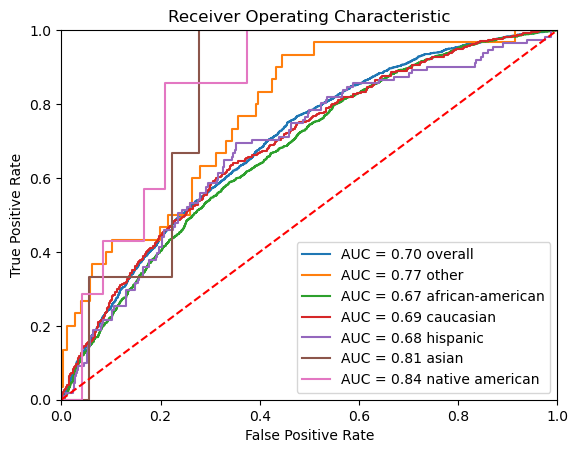

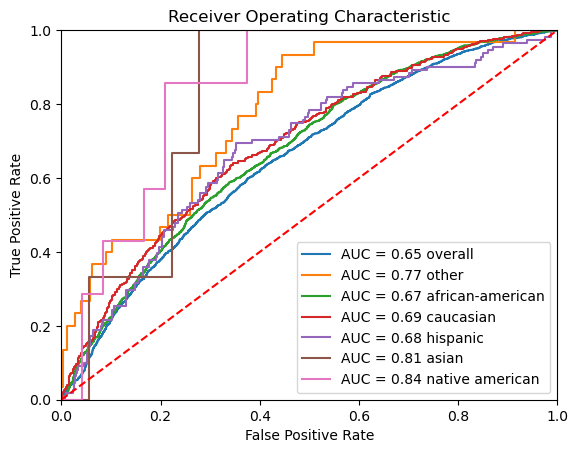

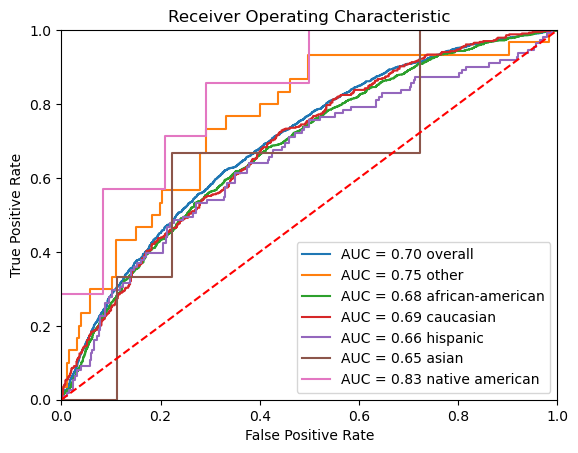

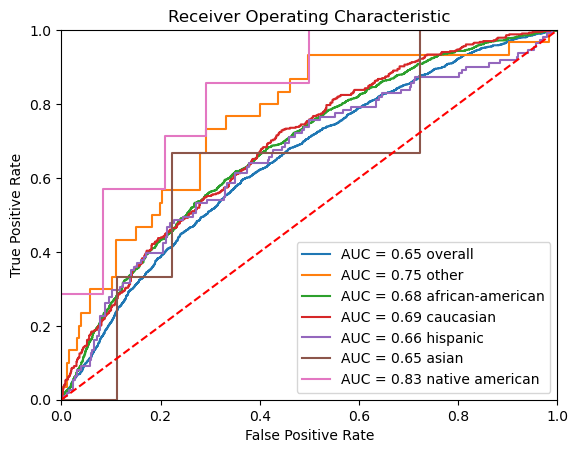

In [19]:
# ROC plots 
roc(predictor, test)
roc(fpredictor, test)

roc(predictor_race, test)
roc(fpredictor_race, test)

In [20]:
# print all columns that are not word-based 

for w in list(test.columns):
    if "word" in w: continue
    if "past" in w: continue
    print(w, end=', ')

age, race, sex, j_felonies, j_misdemeanor, j_other, felonies_case, misdemeanors_case, other_cases, felonies_charge, misdemeanors_charge, other_charges, pred_label, total_felonies_charges, total_misdemeanors_charges, total_other_cases, 3_felonies_case, 3_misdemeanors_case, 3_other_cases, 3_total_prison, 3_total_jail, 3_time_norm, 2_felonies_case, 2_misdemeanors_case, 2_other_cases, 2_total_prison, 2_total_jail, 2_time_norm, 1_felonies_case, 1_misdemeanors_case, 1_other_cases, 1_total_prison, 1_total_jail, 1_time_norm, 5_felonies_case, 5_misdemeanors_case, 5_other_cases, 5_total_prison, 5_total_jail, 5_time_norm, 4_felonies_case, 4_misdemeanors_case, 4_other_cases, 4_total_prison, 4_total_jail, 4_time_norm, probs, 

In [22]:
# Random  baseline performance 

import numpy as np
from sklearn.metrics import classification_report
#test random performance
rand_y = np.random.randint(0, 2, len(test))

print(classification_report(rand_y, test['pred_label']))

y_pred = fpredictor.predict(test.drop(columns = ['pred_label']))
print(classification_report(y_pred, test['pred_label']))

              precision    recall  f1-score   support

           0       0.51      0.73      0.61      3843
           1       0.50      0.27      0.35      3662

    accuracy                           0.51      7505
   macro avg       0.51      0.50      0.48      7505
weighted avg       0.51      0.51      0.48      7505

              precision    recall  f1-score   support

           0       0.59      0.83      0.69      3920
           1       0.66      0.37      0.48      3585

    accuracy                           0.61      7505
   macro avg       0.63      0.60      0.58      7505
weighted avg       0.62      0.61      0.59      7505



In [21]:
# generate group statistics for the report 

def counts_by_group(df):
   results = {}
   vals = df['race'].unique()
   vc = {}
   for i, r in df['race'].value_counts().items():
      vc[i]=r
   vc['total'] = df.shape[0]
   results['Number of Data Points'] = vc.copy()

    
   for v in vals:
      vc[v] = df.loc[(df['race']==v) & (df['pred_label']==1)].shape[0]
   vc['total'] = df.loc[(df['pred_label']==1)].shape[0]
   
   results['Positive Count'] = vc.copy()

   for v in vals:
      vc[v] = df.loc[(df['race']==v) & (df['pred_label']==0)].shape[0]
   vc['total'] = df.loc[(df['pred_label']==0)].shape[0]
   
   results['Negative Count'] = vc.copy() 
   return results     
   #results['Number of Datapoints'] = 


In [23]:
# group statistics by dataset 

val = pd.read_parquet(f'joined_data/compas_v1_all_{years}y-label_val.pqt')
for n, v in {'train':train, 'test':test, 'val':val}.items():
    counts = pd.DataFrame(counts_by_group(v))
    counts.index.name = 'Groups'
    counts.to_csv(f'counts-{n}.csv')

In [24]:
# calculate precision at 10 with random repeted sampling 

def top_n(model, fmodel, test, samples=100, n=10, reps=100, sort_fair=True):
    probs = model.predict_proba(test)
    test['probs'] = probs.iloc[:,1]
    probs = fmodel.predict_proba(test)
    test['probs_fair'] = probs.iloc[:,1]
    sort_col = 'probs'
    if sort_fair:
        sort_col = 'probs_fair'
    total_score = {'overall':0}
    groups = test['race'].unique()
    for g in groups:
        total_score[g] = 0
    for r in range(reps):
        sample_df = test.sample(samples, axis=0)
        sorted_df = sample_df.sort_values(sort_col,  ascending=False)
        top_n = sorted_df[['probs', 'probs_fair', 'pred_label', 'race']].head(n)
        
        score = top_n[(top_n[sort_col] >= 0.5) & (top_n['pred_label'] == 1)].shape[0]/n
        total_score['overall'] += score
        for g in groups:
            total_score[g] += top_n[(top_n[sort_col] >= 0.5) & 
                                   (top_n['pred_label'] == 1) &
                                   (top_n['race'] == g)].shape[0]/n
    for t in total_score:
        total_score[t] = total_score[t]/reps
    display(total_score)

In [25]:
# top 10 experiment 

top_n(predictor, fpredictor, test, sort_fair=False)
top_n(predictor, fpredictor, test, sort_fair=True)
top_n(predictor_race, fpredictor_race, test, sort_fair=False)
top_n(predictor_race, fpredictor_race, test, sort_fair=True)


{'overall': 0.4990000000000002,
 'other': 0.002,
 'african-american': 0.40899999999999986,
 'caucasian': 0.06699999999999996,
 'hispanic': 0.018000000000000006,
 'asian': 0.0,
 'native american': 0.0030000000000000005}

{'overall': 0.4419999999999997,
 'other': 0.013000000000000003,
 'african-american': 0.21699999999999992,
 'caucasian': 0.14499999999999993,
 'hispanic': 0.06299999999999996,
 'asian': 0.002,
 'native american': 0.002}

{'overall': 0.5420000000000001,
 'other': 0.006000000000000001,
 'african-american': 0.4299999999999999,
 'caucasian': 0.08199999999999996,
 'hispanic': 0.022000000000000006,
 'asian': 0.0,
 'native american': 0.002}

{'overall': 0.4219999999999998,
 'other': 0.03400000000000001,
 'african-american': 0.18299999999999997,
 'caucasian': 0.14799999999999985,
 'hispanic': 0.05599999999999999,
 'asian': 0.0,
 'native american': 0.001}

In [26]:
# number of null values in the data 

data = pd.read_parquet(f'joined_data/compas_v1_all_{years}y-label.pqt')
print(data.shape)
print(data.shape[0]*data.shape[1])
print(data.isnull().sum().sum())

(38774, 860)
33345640
398808


In [28]:
# Calculate feature importance
# feature importance not supported by fpredictor at this time

feature_importance_o = predictor.feature_importance(data=test, features=None)


These features in provided data are not utilized by the predictor and will be ignored: ['race', 'word_loitering', 'word_toll', 'word_hours', 'word_chur', 'word_mot', 'word_right', 'word_proper', 'word_offender', 'word_forged', 'word_limit', 'word_proh', 'word_amp', 'word_kidnapping', 'word_refuse', 'word_animal', 'word_check', 'word_soliciting', 'word_prohib', 'word_noise', 'word_fac', 'word_vessel', 'word_exploit', 'word_perform', 'word_deliv', 'word_drinking', 'word_sleep', 'word_load', 'word_bicycle', 'word_dog', 'word_vin', 'word_cmv', 'word_curb', 'word_dealer', 'word_peace', 'word_scene', 'word_court', 'word_church', 'word_phone', 'word_temp', 'word_city', 'word_fish', 'word_large', 'word_food', 'word_remove', 'word_death', 'word_running', 'word_statement', 'past_subs', 'past_animals', 'past_proh', 'past_amp', 'past_check', 'past_soliciting', 'past_exploit', 'past_fire', 'past_report', 'past_vin', 'past_dealer', 'past_scene', 'past_remove', 'past_statement', 'probs', 'probs_fair'

In [29]:
display(feature_importance_o.head(30))

,importance,stddev,p_value,n,p99_high,p99_low
total_felonies_charges,0.022763,0.003953,0.000105,5,0.030902,0.014624
total_past_incidents,0.020789,0.003690,0.000114,5,0.028386,0.013192
total_misdemeanors_charges,0.017170,0.002246,0.000034,5,0.021794,0.012546
past_possession,0.007608,0.002738,0.001708,5,0.013246,0.001970
5_felonies_case,0.007510,0.001540,0.000201,5,0.010682,0.004339
word_battery,0.007206,0.001864,0.000492,5,0.011043,0.003368
past_felony,0.004983,0.001529,0.000941,5,0.008131,0.001836
misdemeanors_case,0.004766,0.001639,0.001442,5,0.008140,0.001392
2_misdemeanors_case,0.004309,0.003603,0.027775,5,0.011728,-0.003109
word_license,0.004153,0.001462,0.001571,5,0.007163,0.001144
